In [4]:
import os
print(os.getcwd())

/Users/charlieshi/Desktop/olist-clv-seg/notebooks


In [5]:
os.chdir("/Users/charlieshi/Desktop/olist-clv-seg")

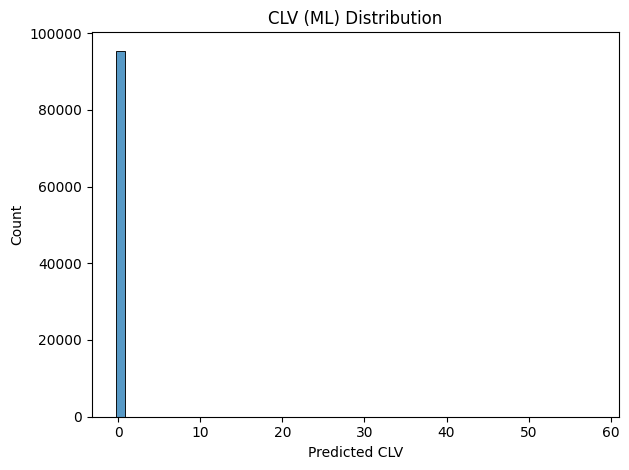


Segment quantiles:
                     Top5         Top20         Mid50
segment_kmeans                                      
0               0.000014  6.730342e-08 -2.372158e-06
1               0.000011  9.090139e-06  5.874501e-06
2               0.000601  6.188254e-05  4.233914e-07


/var/folders/4q/l1gskkd14t75n5pn3p0zprs80000gn/T/ipykernel_70840/3468718623.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


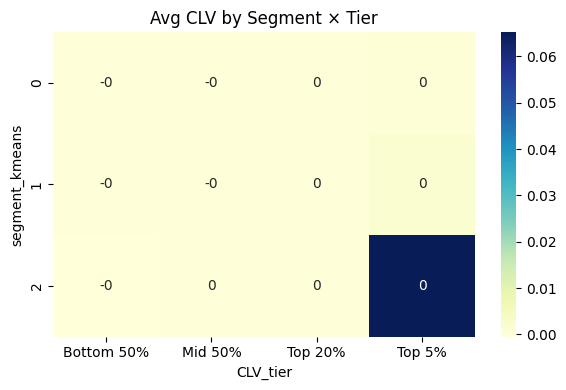

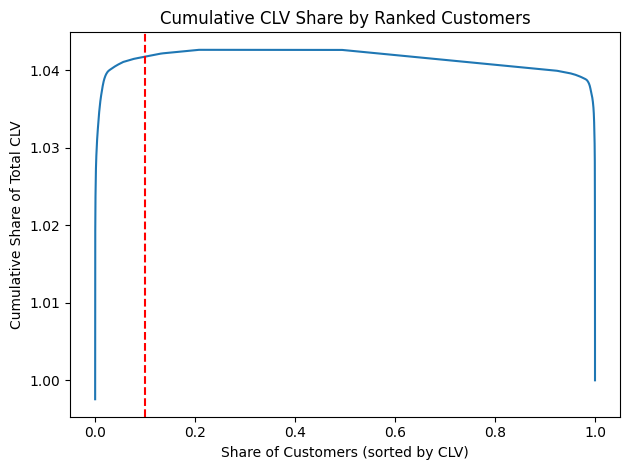

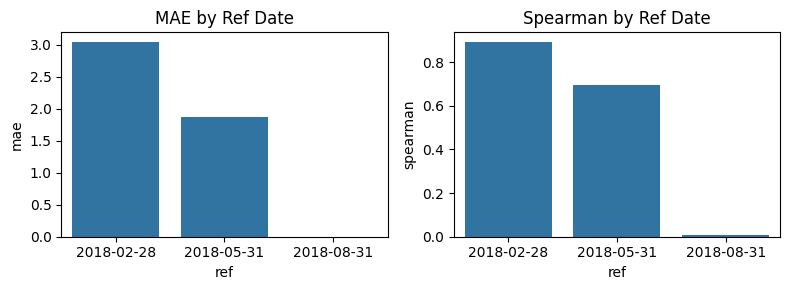

In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os

# 读取数据
features_dir = "data/features"
outputs_dir = "data/outputs"
seg = pd.read_parquet(os.path.join(features_dir, "customer_segments_kmeans.parquet"))
clv = pd.read_parquet(os.path.join(outputs_dir, sorted([f for f in os.listdir(outputs_dir) if f.startswith("CLV_ML_")])[-1]))
df = seg.merge(clv, on="customer_unique_id", how="left")

# 图1：CLV 分布
plt.figure()
sns.histplot(df["clv_ml_pred"], bins=50)
plt.title("CLV (ML) Distribution")
plt.xlabel("Predicted CLV")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 图2：Segment × CLV 热力图（平均 CLV）
mat = (df.groupby(["segment_kmeans"])
         .apply(lambda g: pd.Series({
             "Top5": g["clv_ml_pred"].quantile(0.95),
             "Top20": g["clv_ml_pred"].quantile(0.80),
             "Mid50": g["clv_ml_pred"].quantile(0.50),
         }))
      )
print("\nSegment quantiles:\n", mat)

# 直接用我们之前导出的矩阵（若已生成）
matrix_path = os.path.join(outputs_dir, "CLV_segment_matrix.csv")
if os.path.exists(matrix_path):
    m = pd.read_csv(matrix_path)
    pivot = m.pivot(index="segment_kmeans", columns="CLV_tier", values="avg_clv")
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("Avg CLV by Segment × Tier")
    plt.tight_layout()
    plt.show()

# 图3：Top-K 累积贡献
df_sorted = df.sort_values("clv_ml_pred", ascending=False).reset_index(drop=True)
df_sorted["cum_share"] = df_sorted["clv_ml_pred"].cumsum() / df_sorted["clv_ml_pred"].sum()
plt.figure()
plt.plot(np.linspace(0,1,len(df_sorted)), df_sorted["cum_share"])
plt.axvline(0.1, color="r", linestyle="--")
plt.title("Cumulative CLV Share by Ranked Customers")
plt.xlabel("Share of Customers (sorted by CLV)")
plt.ylabel("Cumulative Share of Total CLV")
plt.tight_layout()
plt.show()

# 图4：回溯验证条形图
import json
cv = json.load(open("models/xgb_clv_cv_metrics.json"))
cv_df = pd.DataFrame(cv)
fig, axes = plt.subplots(1,2,figsize=(8,3))
sns.barplot(data=cv_df, x="ref", y="mae", ax=axes[0])
axes[0].set_title("MAE by Ref Date")
sns.barplot(data=cv_df, x="ref", y="spearman", ax=axes[1])
axes[1].set_title("Spearman by Ref Date")
plt.tight_layout(); plt.show()

In [ ]:
os.chdir("/Users/charlieshi/Desktop/olist-clv-seg")